In [2]:
!pip install ultralytics -q

import os
import shutil
import random
import json
import glob
import re
import numpy as np
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab import drive
import yaml
from ultralytics import YOLO


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Define absolute paths
BASE_DIR = "/content/drive/Othercomputers/ה-Mac שלי/StormVision"

# Input paths (Source data)
PAIRED_DIR = os.path.join(BASE_DIR, "storm_synth_out_onefolder/Combination")
ORIG_COCO_TRAIN = os.path.join(BASE_DIR, "data/annotations/instances_train.json")
ORIG_COCO_VAL = os.path.join(BASE_DIR, "data/annotations/instances_val.json")
SYNTH_COCO = os.path.join(BASE_DIR, "storm_synth_out_onefolder/instances_synth.json")

# Output paths (Workspace)
WORK_DIR = os.path.join(BASE_DIR, "output_dataset_pairs")
RUNS_DIR = os.path.join(BASE_DIR, "output_runs_stormvision")

# Cleanup: Remove old dataset directory to ensure a fresh start
if os.path.exists(WORK_DIR):
    print(f"Removing old work directory: {WORK_DIR}...")
    shutil.rmtree(WORK_DIR)

# Create necessary directories
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(RUNS_DIR, exist_ok=True)

print("Setup complete. Workspace ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive
Removing old work directory: /content/drive/Othercomputers/ה-Mac שלי/StormVision/output_dataset_pairs...
Setup complete. Workspace ready.


In [3]:
# Map specific COCO categories to our custom classes
# Class 0: Person (includes swimmers)
# Class 1: Boat (includes jetskis, life saving appliances, buoys)
CLASS_MAPPING = {
    'person': 0, 'swimmer': 0,
    'boat': 1, 'jetski': 1, 'life_saving_appliances': 1, 'buoy': 1
}

def process_dataset(paired_dir, work_dir, json_paths):
    print("Loading COCO Annotations...")
    idx_map = {'ORIG': {}, 'SYNTH': {}}

    # Helper function to load JSON and map annotations
    def load_json(path, target_dict):
        with open(path, 'r') as f:
            data = json.load(f)

        # Create map from local category ID to our custom ID (0 or 1)
        local_id_map = {}
        for cat in data['categories']:
            cname = cat['name'].lower()
            if cname in CLASS_MAPPING:
                local_id_map[cat['id']] = CLASS_MAPPING[cname]

        # Map annotations to images
        img_lookup = {img['id']: img for img in data['images']}
        for ann in data['annotations']:
            cid = local_id_map.get(ann['category_id'])
            if cid is None:
                continue # Skip irrelevant classes

            img_info = img_lookup.get(ann['image_id'])
            if not img_info:
                continue

            fname = img_info['file_name']
            if fname not in target_dict:
                target_dict[fname] = {'w': img_info['width'], 'h': img_info['height'], 'boxes': []}

            # Convert COCO bbox [x, y, w, h] to YOLO format [class, x_center, y_center, w, h]
            x, y, w, h = ann['bbox']
            W, H = img_info['width'], img_info['height']

            # Normalize coordinates
            target_dict[fname]['boxes'].append([
                cid,
                (x + w/2)/W, (y + h/2)/H, w/W, h/H
            ])

    # Load all JSON files
    load_json(json_paths['orig_train'], idx_map['ORIG'])
    load_json(json_paths['orig_val'], idx_map['ORIG'])
    load_json(json_paths['synth'], idx_map['SYNTH'])

    print("Organizing Files and Splitting Dataset...")
    all_files = os.listdir(paired_dir)

    # Group files by Pair ID to prevent data leakage between splits
    pair_dict = defaultdict(list)
    for f in all_files:
        if 'pair_' in f and f.endswith('.jpg'):
            # Extract Pair ID (e.g., pair_0001)
            match = re.search(r'(pair_\d+)_', f)
            if match:
                pair_dict[match.group(1)].append(f)

    pair_ids = sorted(list(pair_dict.keys()))
    random.shuffle(pair_ids)

    # Split Ratios: 70% Train, 15% Val, 15% Test
    n = len(pair_ids)
    splits = {
        'train': pair_ids[:int(n*0.7)],
        'val': pair_ids[int(n*0.7):int(n*0.85)],
        'test': pair_ids[int(n*0.85):]
    }

    counts = defaultdict(int)

    # Process each split
    for split_name, pids in splits.items():
        img_dir = os.path.join(work_dir, 'images', split_name)
        lbl_dir = os.path.join(work_dir, 'labels', split_name)
        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(lbl_dir, exist_ok=True)

        for pid in pids:
            for fname in pair_dict[pid]:
                # 1. Copy Image
                shutil.copy2(os.path.join(paired_dir, fname), os.path.join(img_dir, fname))

                # 2. Generate Label File
                # Determine type (ORIG or SYNTH) and extract real filename key
                ftype = 'ORIG' if 'ORIG' in fname else 'SYNTH'
                match_name = re.search(r'pair_\d+_(ORIG|SYNTH)_(.*)', fname)
                if match_name:
                    real_name = match_name.group(2)
                else:
                    continue

                # Retrieve annotation data
                data = idx_map[ftype].get(real_name)
                # Fallback: try appending .jpg extension if key lookup fails
                if not data and (real_name + '.jpg') in idx_map[ftype]:
                    data = idx_map[ftype][real_name + '.jpg']

                # Write YOLO .txt file if data exists
                if data:
                    txt_path = os.path.join(lbl_dir, fname.replace('.jpg', '.txt'))
                    with open(txt_path, 'w') as f:
                        for b in data['boxes']:
                            f.write(f"{b[0]} {b[1]:.6f} {b[2]:.6f} {b[3]:.6f} {b[4]:.6f}\n")
                    counts[split_name] += 1

    print(f"Processing Done. Created labels for: Train: {counts['train']}, Val: {counts['val']}, Test: {counts['test']}")

    # Create dataset.yaml for YOLO
    yaml_content = f"""
path: {work_dir}
train: images/train
val: images/val
test: images/test
names:
  0: person
  1: boat
"""
    with open(os.path.join(work_dir, 'dataset.yaml'), 'w') as f:
        f.write(yaml_content)

# Run the processing function
process_dataset(PAIRED_DIR, WORK_DIR, {
    'orig_train': ORIG_COCO_TRAIN,
    'orig_val': ORIG_COCO_VAL,
    'synth': SYNTH_COCO
})

Loading COCO Annotations...
Organizing Files and Splitting Dataset...
Processing Done. Created labels for: Train: 311, Val: 68, Test: 71


In [4]:
# Initialize a pre-trained YOLOv8s model
model_b = YOLO('yolov8s.pt')

print("Starting Training...")

# Train model on both classes (0 and 1) to learn distinction
results = model_b.train(
    data=os.path.join(WORK_DIR, 'dataset.yaml'),
    project=RUNS_DIR,
    name='Model_B_Final',
    epochs=25,
    imgsz=1024,      # High resolution for small objects
    batch=8,
    patience=10,
    plots=False,
    exist_ok=True,
    verbose=True
)

print("Training Complete.")

Starting Training...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/Othercomputers/ה-Mac שלי/StormVision/output_dataset_pairs/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Model_B_Final, nbs=64, nms=False, opset=None, op

In [10]:
# @title 6. Advanced Evaluation: Real vs. Synthetic Analysis

def create_subset_yaml(work_dir, base_yaml_path, filter_str):
    """Creates a temporary YAML file for a specific subset (ORIG or SYNTH)."""
    # 1. Find images matching the filter
    test_img_dir = os.path.join(work_dir, 'images/test')
    all_imgs = glob.glob(os.path.join(test_img_dir, "*.jpg"))
    subset_imgs = [img for img in all_imgs if filter_str in os.path.basename(img)]

    if not subset_imgs:
        print(f"⚠️ Warning: No images found for filter '{filter_str}'")
        return None

    # 2. Create image list file (.txt)
    subset_txt_path = os.path.join(work_dir, f'test_{filter_str}.txt')
    with open(subset_txt_path, 'w') as f:
        f.write('\n'.join(subset_imgs))

    # 3. Create new YAML pointing to this list
    with open(base_yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    yaml_data['test'] = subset_txt_path
    yaml_data['val'] = subset_txt_path # For validation mode

    subset_yaml_path = os.path.join(work_dir, f'dataset_{filter_str}.yaml')
    with open(subset_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)

    return subset_yaml_path

def evaluate_model_on_split(model, yaml_path, split_name):
    """Runs validation and returns dict of metrics."""
    results = model.val(
        data=yaml_path,
        split='test',
        imgsz=1024,
        batch=8,
        verbose=False,
        plots=False,
        classes=[0] # Only Person
    )
    p, r = results.box.mp, results.box.mr
    f1 = 2 * (p * r) / (p + r + 1e-6)
    return {
        'Precision': p,
        'Recall': r,
        'F1': f1,
        'mAP50': results.box.map50
    }

# --- Main Evaluation Flow ---

# Load Models
print("1️⃣ Loading Models...")
model_a = YOLO('yolov8s.pt') # Baseline
weights_path = os.path.join(RUNS_DIR, 'Model_B_Final/weights/best.pt')
if not os.path.exists(weights_path):
    raise FileNotFoundError("Model B weights not found. Did you run training?")
model_b = YOLO(weights_path) # Finetuned

# Prepare Subsets
base_yaml = os.path.join(WORK_DIR, 'dataset.yaml')
yaml_orig = create_subset_yaml(WORK_DIR, base_yaml, 'ORIG')
yaml_synth = create_subset_yaml(WORK_DIR, base_yaml, 'SYNTH')

# Container for results
eval_data = []

# Loop through scenarios
scenarios = [
    ('Real Data', yaml_orig),
    ('Synthetic Data', yaml_synth)
]

print("\n2️⃣ Starting Split Evaluation...")
for data_name, yaml_file in scenarios:
    if not yaml_file: continue

    print(f"\n--- Evaluating on {data_name} ---")

    # Model A (Baseline)
    print(f"   > Testing Baseline Model...")
    res_a = evaluate_model_on_split(model_a, yaml_file, data_name)
    res_a.update({'Model': 'Baseline', 'Data Type': data_name})
    eval_data.append(res_a)

    # Model B (Finetuned)
    print(f"   > Testing Finetuned Model...")
    res_b = evaluate_model_on_split(model_b, yaml_file, data_name)
    res_b.update({'Model': 'Finetuned', 'Data Type': data_name})
    eval_data.append(res_b)

# Create DataFrame
df_split = pd.DataFrame(eval_data)
print("\n✅ Evaluation Complete. Data prepared for plotting.")
display(df_split.round(3))

1️⃣ Loading Models...

2️⃣ Starting Split Evaluation...

--- Evaluating on Real Data ---
   > Testing Baseline Model...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.0 ms, read: 301.7±137.0 MB/s, size: 851.8 KB)
val: Scanning /content/drive/Othercomputers/ה-Mac שלי/StormVision/output_dataset_pairs/labels/test... 45 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 45/45 263.0it/s 0.2s
val: New cache created: /content/drive/Othercomputers/ה-Mac שלי/StormVision/output_dataset_pairs/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 6.1it/s 1.0s
                   all         45        129      0.225      0.295      0.184     0.0733
Speed: 1.1ms preprocess, 2.3ms inference, 0.0ms loss, 1.1ms postprocess per image
   > Testing Finetuned Mode

,Precision,Recall,F1,mAP50,Model,Data Type
0,0.225,0.295,0.255,0.184,Baseline,Real Data
1,0.700,0.659,0.679,0.650,Finetuned,Real Data
2,0.160,0.116,0.135,0.082,Baseline,Synthetic Data
3,0.615,0.527,0.568,0.488,Finetuned,Synthetic Data


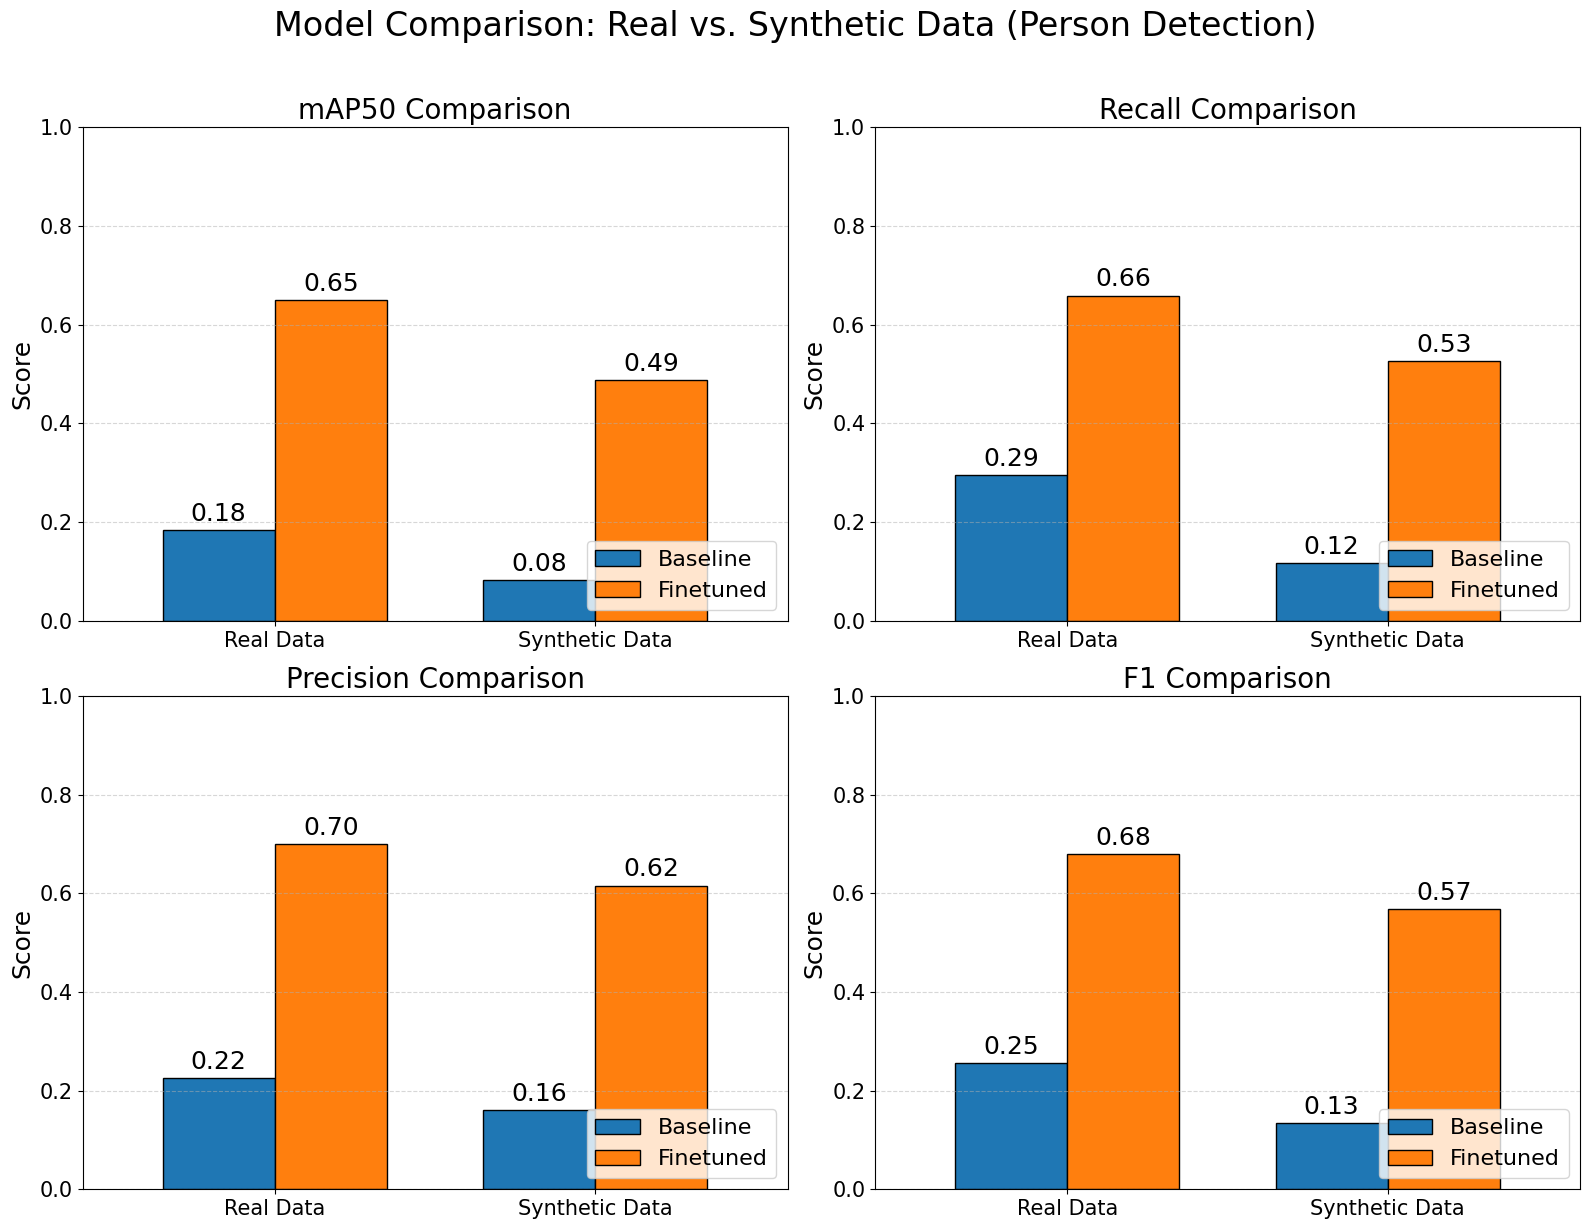

In [19]:
# @title 5. Visualization: Comparative Graphs (Large Fonts, Regular Weight)

def plot_split_graphs(df):
    metrics = ['mAP50', 'Recall', 'Precision', 'F1']

    # Create 2x2 grid of plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Colors
    colors = {'Baseline': '#1f77b4', 'Finetuned': '#ff7f0e'} # Blue vs Orange

    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Prepare data
        pivot_df = df.pivot(index='Data Type', columns='Model', values=metric)

        # Plot (rot=0 keeps text straight)
        pivot_df.plot(kind='bar', ax=ax, color=[colors[c] for c in pivot_df.columns],
                      width=0.7, edgecolor='black', rot=0)

        # --- Styling Updates ---
        # 1. Title: Larger font (18), removed 'bold'
        ax.set_title(f'{metric} Comparison', fontsize=20)

        # 2. Axis Labels: Larger font (14)
        ax.set_ylabel('Score', fontsize=18)
        ax.set_xlabel('')

        # 3. Ticks (The text on X and Y axis): Larger font (13)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.set_ylim(0, 1.0) # Little more space on top
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        # 4. Legend: Larger font (12)
        ax.legend(loc='lower right', fontsize=16)

        # 5. Bar Values (Numbers on top): Larger font (12), removed 'bold'
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=18)

    # Main Title: Larger font (24)
    plt.suptitle("Model Comparison: Real vs. Synthetic Data (Person Detection)", fontsize=24, y=1.02)
    plt.tight_layout()
    plt.show()

if 'df_split' in locals() and not df_split.empty:
    plot_split_graphs(df_split)
else:
    print("❌ No data to plot. Please run Cell 4 first.")

In [7]:
def visualize_improvements(model_a, model_b, work_dir, top_k=5):
    """
    Finds and plots test images where Model B has higher confidence than Model A.
    """
    test_img_dir = os.path.join(work_dir, 'images/test')
    test_files = glob.glob(os.path.join(test_img_dir, "*.jpg"))

    gap_cases = []
    print(f"Scanning {len(test_files)} test images for improvements...")

    for i, img_path in enumerate(test_files):
        im = cv2.imread(img_path)
        if im is None: continue

        # Run inference on both models, strictly for Class 0 (Person)
        res_a = model_a(im, verbose=False, classes=[0])[0]
        res_b = model_b(im, verbose=False, classes=[0])[0]

        # Get max confidence score for each model
        conf_a = res_a.boxes.conf.max().item() if len(res_a.boxes) > 0 else 0.0
        conf_b = res_b.boxes.conf.max().item() if len(res_b.boxes) > 0 else 0.0

        # Calculate confidence gap
        gap = conf_b - conf_a

        # Filter: Positive gap and Model B has decent confidence
        if gap > 0.1 and conf_b > 0.25:
            gap_cases.append((img_path, gap, conf_a, conf_b))

    # Sort by largest gap
    gap_cases.sort(key=lambda x: x[1], reverse=True)

    print(f"Found {len(gap_cases)} cases with significant improvement.")

    # Plot top K results
    for img_path, gap, ca, cb in gap_cases[:top_k]:
        im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        # Generate plots (bounding boxes)
        res_plot_a = model_a(im, verbose=False, classes=[0])[0].plot()
        res_plot_b = model_b(im, verbose=False, classes=[0])[0].plot()

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle(f"Improvement Gap: +{gap:.2f} (Baseline: {ca:.2f} -> Finetuned: {cb:.2f})", fontsize=16)

        ax[0].imshow(res_plot_a)
        ax[0].set_title("Baseline (Standard YOLO)")
        ax[0].axis('off')

        ax[1].imshow(res_plot_b)
        ax[1].set_title("Finetuned (Your Model)")
        ax[1].axis('off')

        plt.show()

# Run visualization
visualize_improvements(model_a, model_b, WORK_DIR, top_k=10)

Output hidden; open in https://colab.research.google.com to view.